In [1]:
# Yolo imports
from __future__ import division
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import numpy as np
import cv2 
import time
import argparse
import os 
import os.path as osp
import pickle as pkl
import pandas as pd
import random
from skimage import io
from matplotlib import pyplot as plt
from ConfidenceThresholdingAndNonMaximumSuppression import *
from NeuralNetwork import *
from Utilities import *

In [2]:
# Lane detection and distance estimation imports
import glob
from skimage import io, data
import matplotlib.image as mpimg
import camera_calibration
import lane_detection
import vanishing_point
#import utilities
import perspective_transform

In [3]:
# YOLO code to be run only once

#Driver values

images = 'imgs/'
batch_size = 1
confidence = 0.5
nms_thesh = 0.4
start = 0
weights_file = 'yolov3.weights'
cfg_file = 'cfg/yolov3.cfg'

reso = 288
det = 'det/'
CUDA = torch.cuda.is_available()

num_classes = 80    #For COCO
classes = load_classes("data/coco.names")

######

#Set up the neural network
print("Loading network.....")
model = Darknet(cfg_file)
model.load_weights(weights_file)
print("Network successfully loaded")

model.net_info["height"] = reso
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0 
assert inp_dim > 32

#If there's a GPU availible, put the model on GPU
if CUDA:
    model.cuda()

#Set the model in evaluation mode
model.eval()
#######

Loading network.....
Network successfully loaded


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1, inplace)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1, inplace)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1, inplace)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): Batch

In [4]:
# Lane detection and distance estimation code to be run only once

ret, mtx, dist, rvecs, tvecs = camera_calibration.calibrate(False)

In [5]:
# YOLO prediction function
# Takes BGR image and returns: 1) image annotated with bounding boxes, 2) list of top left and bottom right
# coordinates of bounding boxes, 3) list of class numbers which correspond to class labels

def get_pred(img):
    read_dir = time.time()
    #Detection phase
    imlist = ['img']

    if not os.path.exists(det):
        os.makedirs(det)

    load_batch = time.time()
    loaded_ims = [cv2.undistort(np.array(img), mtx, dist, None, mtx)]
    
    #PyTorch Variables for images
    im_batches = list(map(prep_image, loaded_ims, [inp_dim for x in range(len(imlist))]))

    #List containing dimensions of original images
    im_dim_list = [(x.shape[1], x.shape[0]) for x in loaded_ims]
    im_dim_list = torch.FloatTensor(im_dim_list).repeat(1,2)

    if CUDA:
        im_dim_list = im_dim_list.cuda()

    leftover = 0
    if (len(im_dim_list) % batch_size):
        leftover = 1

    if batch_size != 1:
        num_batches = len(imlist) // batch_size + leftover            
        im_batches = [torch.cat((im_batches[i*batch_size : min((i +  1)*batch_size, len(im_batches))]))  for i in range(num_batches)]  

    write = 0
    start_det_loop = time.time()
    
    for i, batch in enumerate(im_batches):
        #load the image 
        start = time.time()
        t = time.time()  
        if CUDA:
            batch = batch.cuda()
        with torch.no_grad():
            prediction = model(Variable(batch), CUDA)
#         print("prediction: " , time.time()-t)    
        t = time.time()    
        prediction = write_results(prediction, confidence, num_classes, nms_conf = nms_thesh)
        end = time.time()

        if type(prediction) == int:

            for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
                im_id = i*batch_size + im_num
#                 print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
#                 print("{0:20s} {1:s}".format("Objects Detected:", ""))
#                 print("----------------------------------------------------------")
            continue

        prediction[:,0] += i*batch_size    #transform the atribute from index in batch to index in imlist 
    
    try:
        if not write:                      #If we have't initialised output
            output = prediction  
            write = 1
        else:
            output = torch.cat((output,prediction))

        for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
            im_id = i*batch_size + im_num
            objs = [classes[int(x[-1])] for x in output if int(x[0]) == im_id]
#             print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
#             print("{0:20s} {1:s}".format("Objects Detected:", " ".join(objs)))
#             print("----------------------------------------------------------")

        if CUDA:
            torch.cuda.synchronize()
#         output
    except:
        print("exception")
        return loaded_ims[0]

    im_dim_list = torch.index_select(im_dim_list, 0, output[:,0].long())

    scaling_factor = torch.min(inp_dim/im_dim_list,1)[0].view(-1,1)

    output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
    output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2

    output[:,1:5] /= scaling_factor

    for i in range(output.shape[0]):
        output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
        output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])

    class_load = time.time()
    colors = pkl.load(open("pallete", "rb"))

    draw = time.time()

    list(map(lambda x: write_img(x, loaded_ims, color = random.choice(colors), classes = classes), output))

    t = time.time()
    det_names = pd.Series(imlist).apply(lambda x: "{}/det_{}".format(det,x.split("/")[-1]))
    
    end = time.time()
    
#     print("SUMMARY")
###     print("----------------------------------------------------------")
###     print("{:25s}: {}".format("Task", "Time Taken (in seconds)"))
###     print()
###     print("{:25s}: {:2.3f}".format("Reading addresses", load_batch - read_dir))
###     print("{:25s}: {:2.3f}".format("Loading batch", start_det_loop - load_batch))
###     print("{:25s}: {:2.3f}".format("Drawing Boxes", end - draw))
#     print("{:25s}: {:2.3f}".format("Average time_per_img", (end - load_batch)/len(imlist)))
#     print("----------------------------------------------------------")

#     t = time.time()
#     torch.cuda.empty_cache()
#     print('= Time to torch.cuda.empty_cache : ', time.time() - t)
   
    return loaded_ims[0], output[:, 1:3], output[:, 3:5], output[:, -1]

In [6]:
# Perspective transform function.
# Takes as input: 1) BGR image, 2) debug mode, 3) YOLO annotated image
# Annotated YOLO image with lines on lanes, and returns: 1) Homography matrix, 2) x pixels per meter, 3) y pixels per meter

def driver_perspective_transform(img_BGR, pred, debug=False):
    ud_img_BGR = cv2.undistort(img_BGR, mtx, dist, None, mtx)
    ud_img_RGB = cv2.cvtColor(ud_img_BGR, cv2.COLOR_BGR2RGB)
    if(debug):
        show_images([ud_img_RGB])
    detector = lane_detection.LaneDetector()
    lines = detector.process(ud_img_RGB, True, 0.16, debug)
    
    vp = vanishing_point.calculate_vanishing_point(lines, ud_img_BGR, debug)
    
    H, H_inv, warped = perspective_transform.perspective_transform(vp, ud_img_BGR, debug)
    
    x_pixels_per_meter , y_pixels_per_meter, left_low, left_high, right_low, right_high = \
                    perspective_transform.get_ratio(H, H_inv, warped, mtx, debug)
    
    # YOLO image with lanes
    cv2.line(pred, (left_low[0], left_low[1]),(left_high[0], left_high[1]),(0,0,255),2)
    cv2.line(pred, (right_low[0], right_low[1]),(right_high[0], right_high[1]),(0,0,255),2)

    return H, x_pixels_per_meter, y_pixels_per_meter

In [7]:
# Distance estimation function
# Takes as input: 1) Query pixel, 2) Bottom center coordinates of screen, 3) homography matrix,
# 4) x pixels per meter, 5) y pixels per meter
# Returns distance to the query pixel

def get_distance(query_pnt, center, H, x_pixels_per_meter, y_pixels_per_meter):
    return perspective_transform.get_distance(query_pnt, center, H, x_pixels_per_meter, y_pixels_per_meter)

(500, 1200, 3)


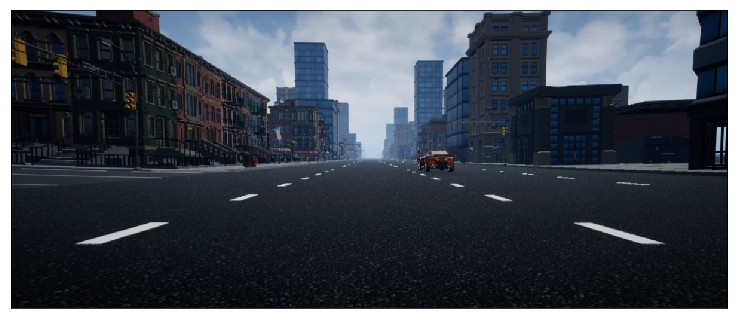

after white color selection


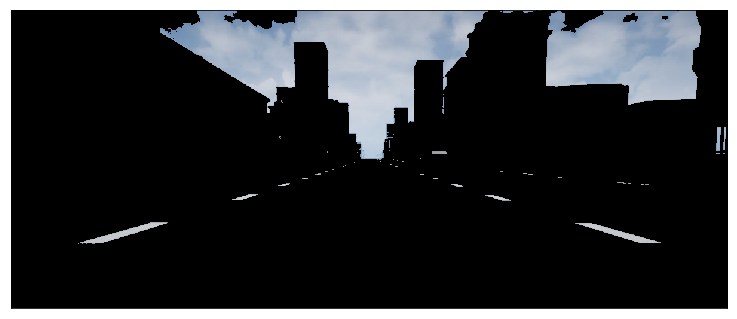

after converting to grayscale


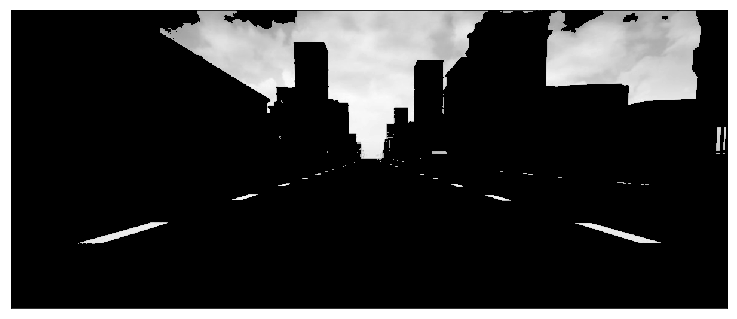

after smoothing


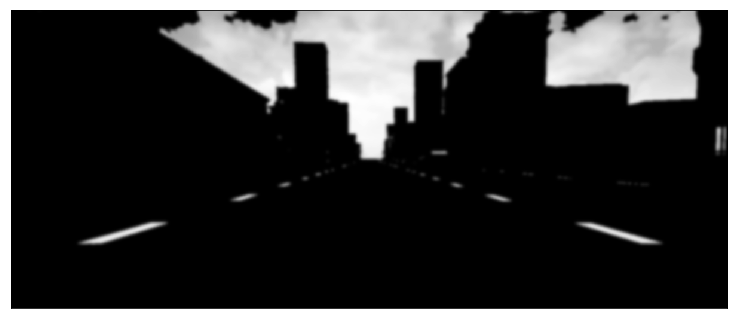

after edge detection


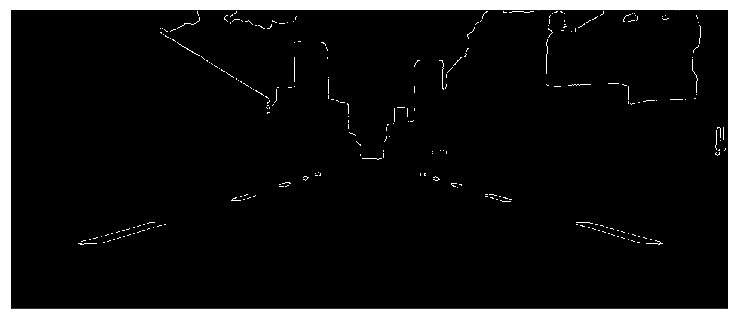

after ROI


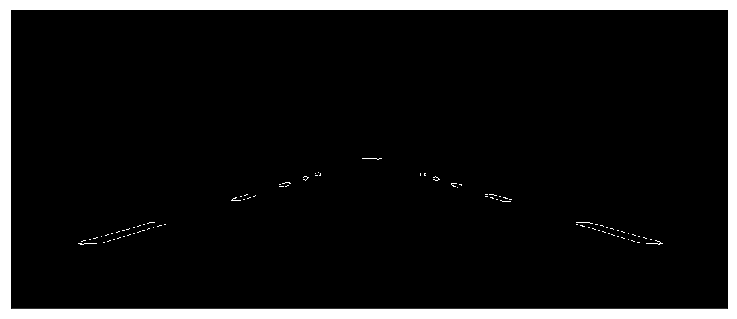

[[598]
 [251]]


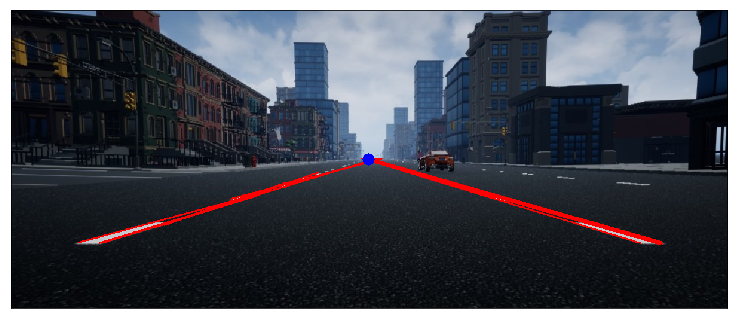

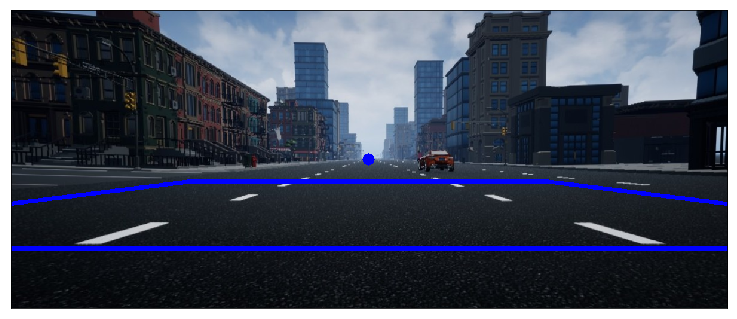

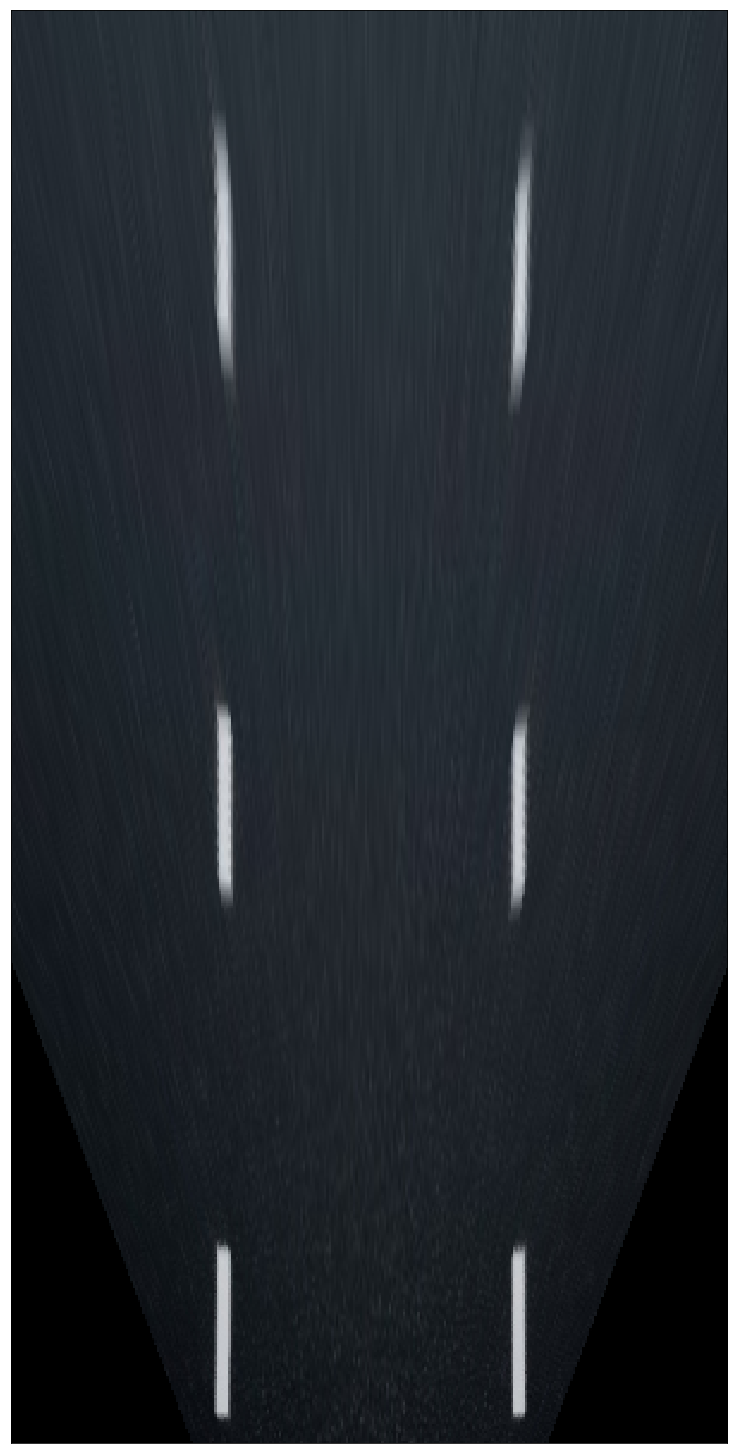

after white color selection


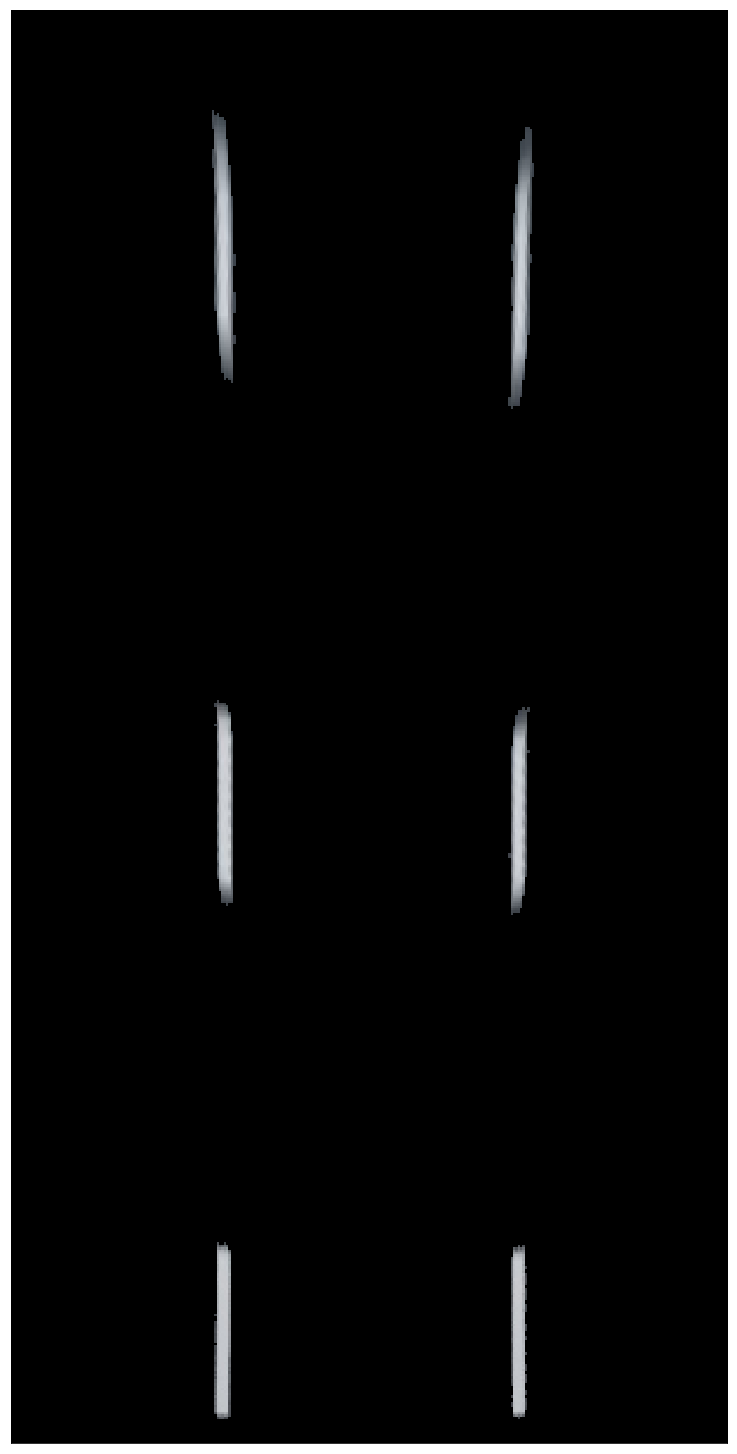

after converting to grayscale


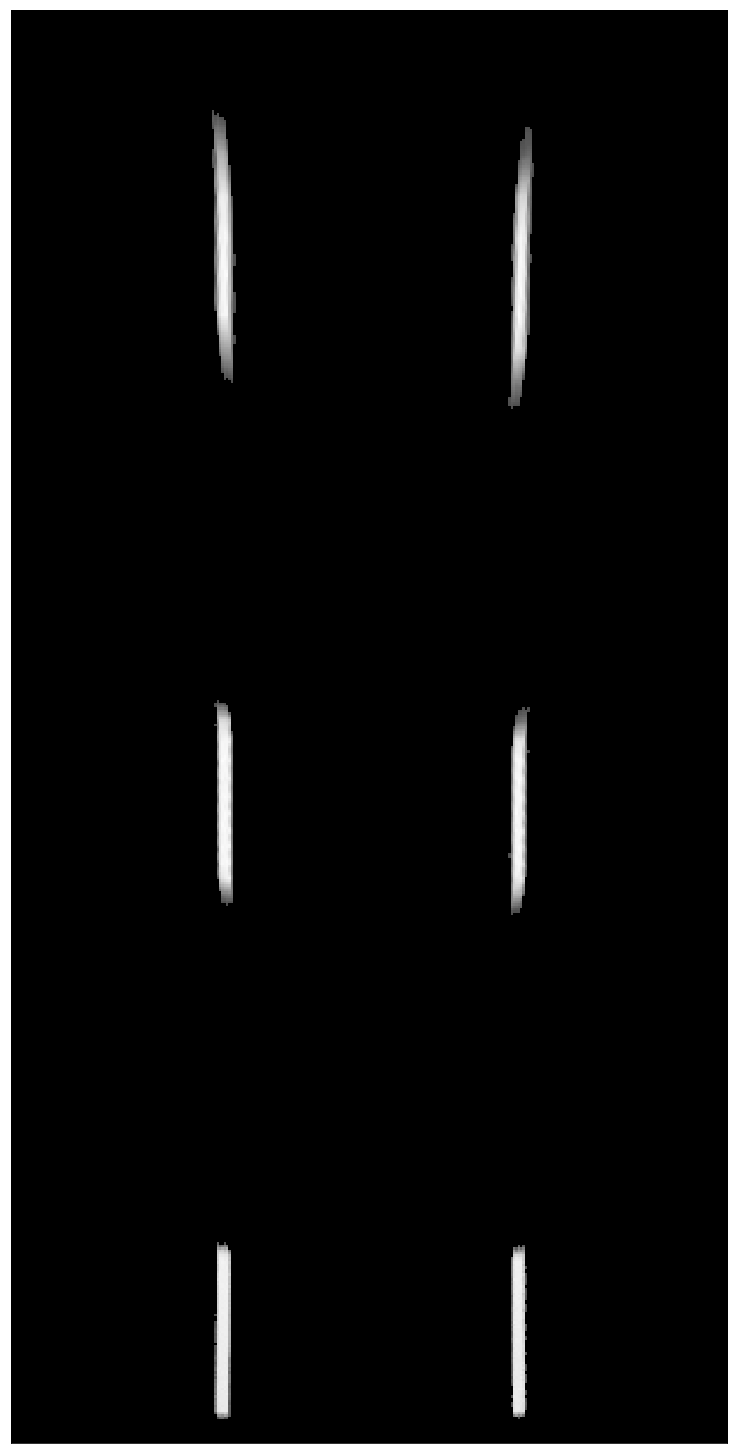

after smoothing


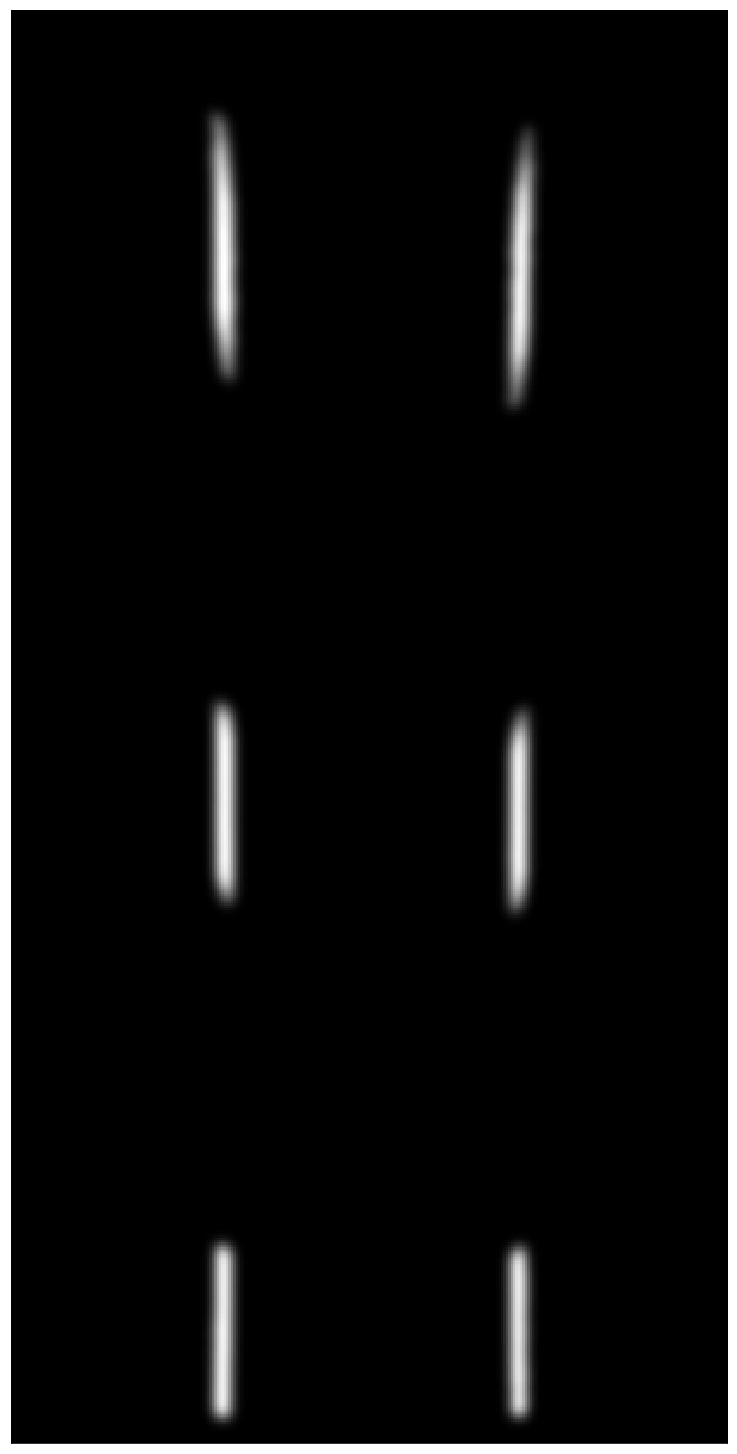

after edge detection


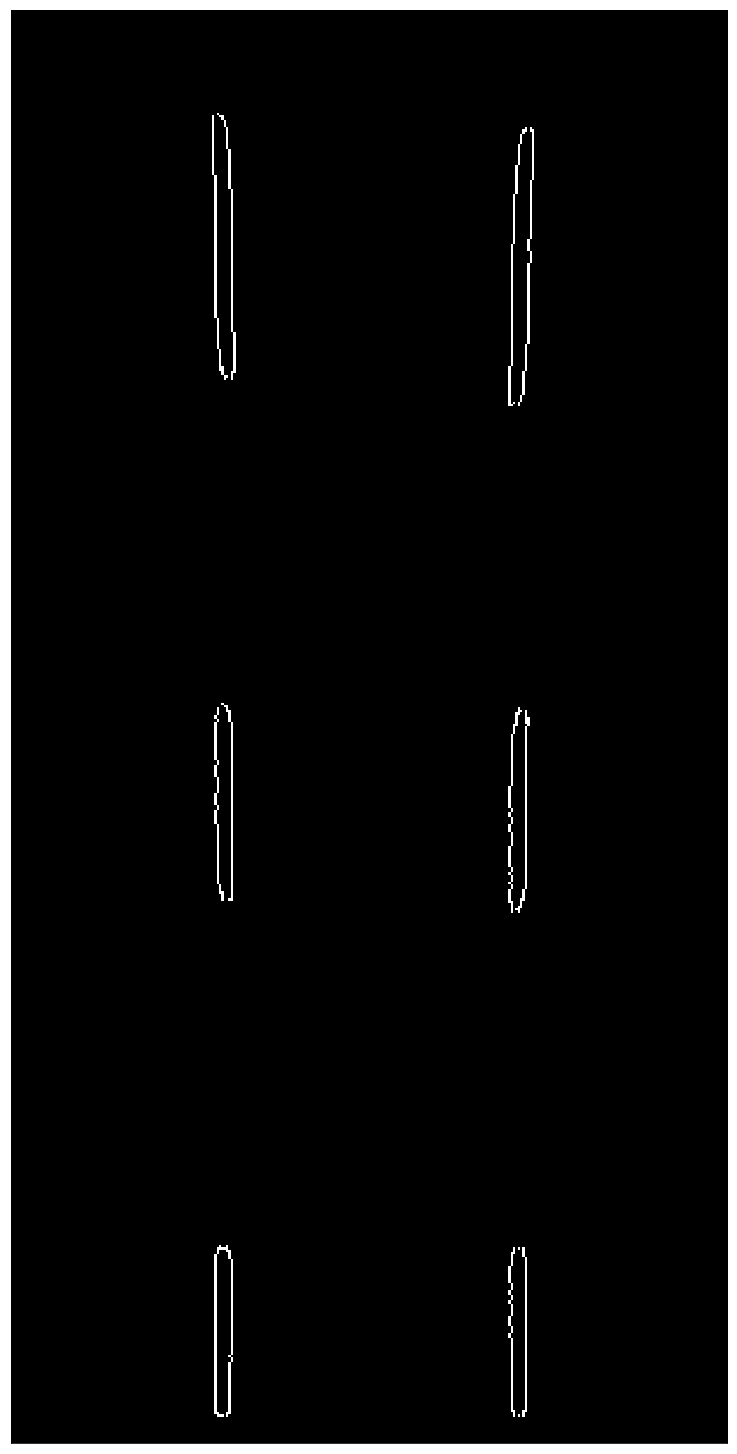

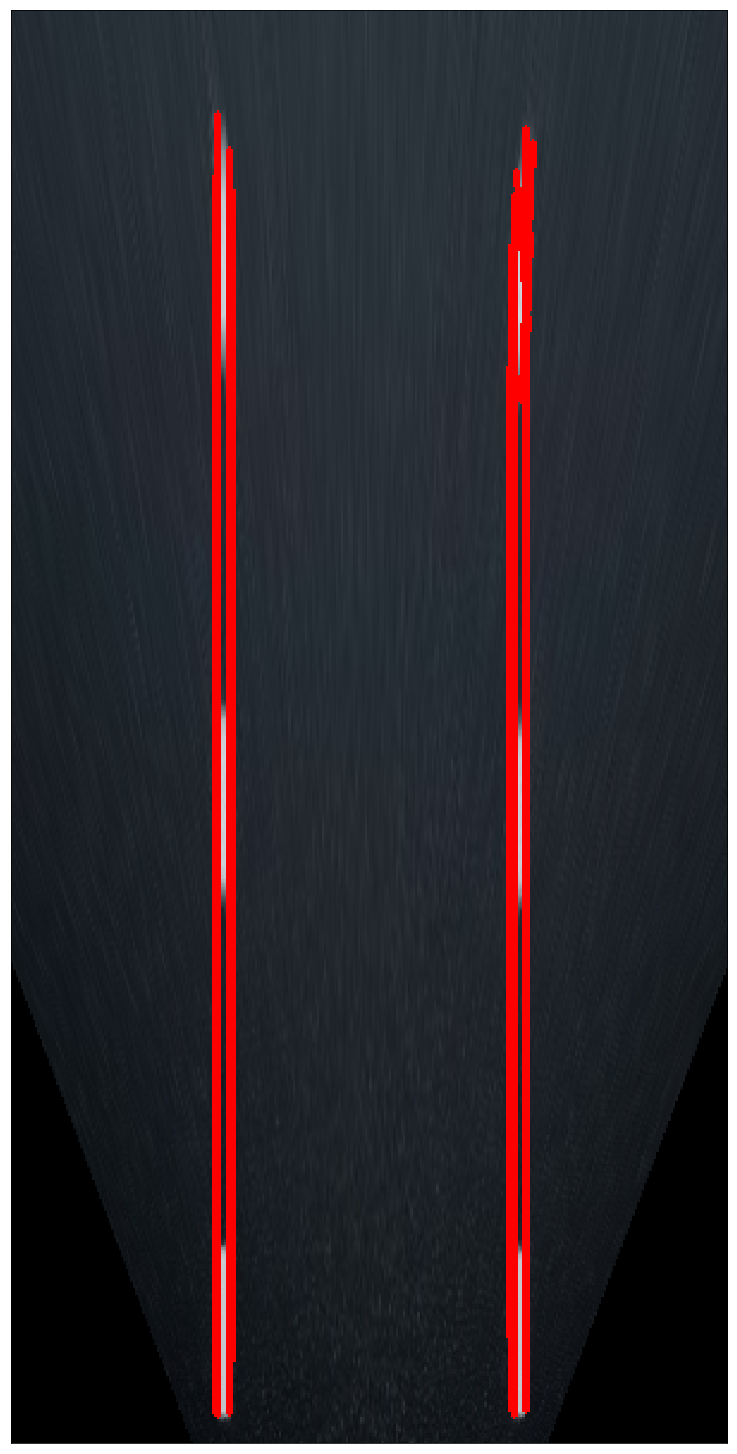

pxls/mtr: 33.90201333333333,46.294379313399894
713,274 | 600,499
33.90201333333333
46.294379313399894


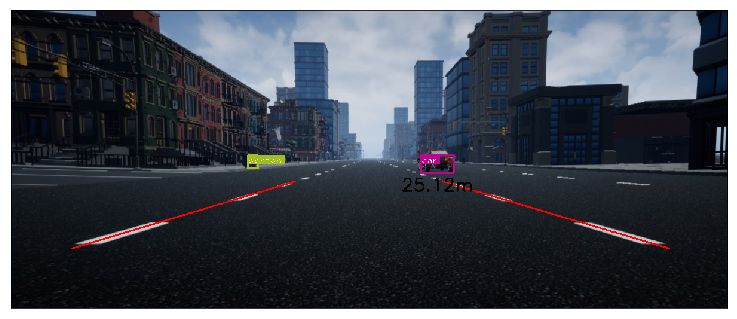

In [16]:
# Reading image
img = cv2.imread('imgs/noshade1200x500.jpg')

print(img.shape)

# Image bottom center coordinates
center = [img.shape[1]//2, img.shape[0]-1]

# Preparing text style that will be used in writing distances
font                   = cv2.FONT_HERSHEY_SIMPLEX
pos = (0,0)
fontScale              = 1
fontColor              = (0,0,0)
lineType               = 2

# Getting predictions from yolo
pred, top_left, bottom_right, labels = get_pred(img)
    
# Perform perspective transform and annotate yolo image
H, x_pixels_per_meter, y_pixels_per_meter = driver_perspective_transform(img, pred, True)
    
# Looping on every detected object
for i in range(len(labels)):
    
    # Object label
    label = classes[int(labels[i])]
    
    if(label != "car"):
        continue
        
    # Top left x,y
    tlx, tly = int(top_left[i,0]), int(top_left[i,1])
    
    # Bottom right x,y
    brx, bry = int(bottom_right[i,0]), int(bottom_right[i,1])
        
    # Bottom center coordinates of bounding box
    cx, cy = (tlx + brx)//2, bry
    
    print(str(cx) + "," + str(cy) + " | " + str(center[0]) + "," + str(center[1]))
    
    # Distance to car
    float_dist = get_distance([cx, cy], center, H, x_pixels_per_meter, y_pixels_per_meter)

    distance = str(round_float(float_dist))+"m"
    
    # Annotate yolo image with distance to car
    cv2.putText(pred,
        distance,
        (cx-60, cy+30), 
        font, 
        fontScale,
        fontColor,
        lineType)

print(x_pixels_per_meter)
print(y_pixels_per_meter)
    
show_images([cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)])

In [9]:
#####
# RUN BLOCK TO CONNECT TO SIM
# Uses local airsim package (DO NOT pip install, UNINSTALL IF INSTALLED ALREADY: "pip uninstall airsim")
import airsim
import io
import threading
from PIL import Image

#I've been experiencing a weird issue. After calling "airsim.CarClient()" the jupyter kernel gets stuck in a loop and no other commands can be run.
#So we going to call it from a new thread
#Call Find_BADAS_Client(), and use client.
def Find_BADAS_ClientNormal():
    global client
    client = airsim.CarClient()
#     client = airsim.CarClient('192.168.1.200')
#     client = airsim.CarClient('192.168.1.12')
def Find_BADAS_Client(): #Thread
    threading.Thread(target=Find_BADAS_ClientNormal).start()

ModuleNotFoundError: No module named 'msgpackrpc'

In [ ]:
Find_BADAS_Client() #Connect to client, call one time

In [ ]:
client.confirmConnection()

In [ ]:
while "Screen capturing":
    
    debug = True # False
    
    t = time.time()
    responses = client.simGetImages([ airsim.ImageRequest("0", airsim.ImageType.Scene, False, False) ])
    response = responses[0]
    img1d = np.fromstring(response.image_data_uint8, dtype=np.uint8) 
    img_rgba = img1d.reshape(response.height, response.width, 4)  
    img_RGB = cv2.cvtColor(img_rgba, cv2.COLOR_RGB2BGR)
    if(debug):
        print ('a', time.time() - t)
    
    t = time.time()
    distance, ud_img_BGR_with_lanes = get_distance(img_RGB, query_pnt, True)
    if(debug):
        print ('b', time.time() - t)
    
    t = time.time()
    cv2.imshow("", ud_img_BGR_with_lanes)
    if(debug):
        print ('c', time.time() - t)
    
    # Press "q" to quit
    if cv2.waitKey(25) & 0xFF == ord("q"):
        cv2.destroyAllWindows()
        break

In [ ]:
Find_BADAS_Client() #Connect to client, call one time

In [ ]:
try:
    while True:
        #starttime = time.time()
        t = time.time()
        responses = client.simGetImages([ airsim.ImageRequest("0", airsim.ImageType.Scene, False, False) ])
        response = responses[0]
        img1d = np.frombuffer(response.image_data_uint8, dtype=np.uint8) 
        img_rgba = img1d.reshape(response.height, response.width, 4)  
        img_rgba = cv2.resize(img_rgba, dsize=(256, 128), interpolation=cv2.INTER_NEAREST) #####################RESIZING FOR FAST PREDICTION
        print('= T Extract sim image: ' , time.time()-t)

        t = time.time()
        detected = get_pred(img_rgba)
        print('= T Detecting: ' , time.time()-t)
        
        cv2.imshow("img", detected)
        #print('=== TOTAL TIME ' , time.time()-starttime , ' ===\n')
        
        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            break
except:
    cv2.destroyAllWindows()

In [ ]:
#Print how many imgs detected
timeout = time.time() + 10 #5 secs

while True:
    if time.time() > timeout:
        break
    x = 0
    start = time.time()
    while True:
        responses = client.simGetImages([ airsim.ImageRequest("0", airsim.ImageType.Scene, False, False) ])
        response = responses[0]
        detected = get_pred((np.frombuffer(response.image_data_uint8, dtype=np.uint8) ).reshape(response.height, response.width, 4))
        if(time.time() - start > 1):
            break
        x += 1

    print(x)

In [ ]:
from skimage import io
import time
img = io.imread('imgs/x2small.jpg')
x = 10
while True:
    x = x -1
    if(x<0):
        break
    t = time.time()
    get_pred(img)
    print('Total time to get detected image: ' , time.time()-t)


In [ ]:
#Print how many imgs detected (local)
from skimage import io
import time
img = io.imread('imgs/x2small.jpg')

timeout = time.time() + 5 #5 secs

while True:
    if time.time() > timeout:
        break
    x = 0
    start = time.time()
    while True:
        t = time.time()
        get_pred(img)
        print('Total time to get detected image: ' , time.time()-t)
        if(time.time() - start > 1):
            break
        x += 1

    print(x)

In [ ]:
import time
x = 100
while True:
    x = x -1
    if x < 0:
        break
    t = time.time()
    png_image = client.simGetImage("1", airsim.ImageType.Scene)
    print('time: ' , time.time()-t)

In [ ]:
#Find_BADAS_Client()
png_image = client.simGetImage("1", airsim.ImageType.Scene)
Image.open(io.BytesIO(png_image)).show()

In [ ]:
t = time.time()
x = (np.frombuffer(response.image_data_uint8, dtype=np.uint8) ).reshape(response.height, response.width, 4)
print('converting image: ' , time.time()-t)

t = time.time()
get_pred(x)
print('Total time to get detected image: ' , time.time()-t)

In [ ]:
Find_BADAS_Client() #Connect to client, call one time

In [ ]:
#Print average of time to detect img
#Find_BADAS_Client()

timeout = time.time() + 10 #5 secs

lst = [] 
lst2 = [] 

while True:
    if time.time() > timeout:
        break
    start = time.time()
    responses = client.simGetImages([ airsim.ImageRequest("0", airsim.ImageType.Scene, False, False) ])
    lst2.append(time.time() - start)
    
    response = responses[0]
    detected = get_pred((np.frombuffer(response.image_data_uint8, dtype=np.uint8) ).reshape(response.height, response.width, 4))
    lst.append(time.time() - start)
        
print("AverageGetImage =", sum(lst2) / len(lst2) ) 
print("AverageAll =", sum(lst) / len(lst) ) 

In [ ]:
#40fps fullscreen quality3 AverageAll = 0.105, AverageGetImage = 0.0021

#over lan 35fps fullscreen quality3
#AverageGetImage = 0.019696117627738725
#AverageAll = 0.09919774414289116

In [ ]:
import time
timeout = time.time() + 5 #5 secs

while True:
    if time.time() > timeout:
        break
    x = 0
    start = time.time()
    while True:
        responses = client.simGetImages([ airsim.ImageRequest("0", airsim.ImageType.Scene, False, False) ])
        response = responses[0]
        #detected = get_pred((np.frombuffer(response.image_data_uint8, dtype=np.uint8) ).reshape(response.height, response.width, 4))
        if(time.time() - start > 1):
            break
        x += 1

    print(x)

In [ ]:
import math
    # a: 0.5 * acc
    # b: vel
    # c: -distance
    
def ThresholdCheck(T):
#     print('T: ', T)
    if(T <= 0.6 && T >= 0):
        return True
    return False

def VisionEmergencyCheck(acc, vel, dist):

    if( acc == 0 ):
        if( vel <= 0 ):
            return False
        ThresholdCheck(dist/vel)
    else:
        a = 0.5 * acc
        b = vel
        c = -dist
        
        d = (b**2) - (4*a*c)
        if(d<0):
#             print('No collision (d<0)')
            return False
        
        T = (-b+math.sqrt(d))/(2*a)
        ThresholdCheck(T)

In [ ]:
VisionEmergencyCheck(-5,5,5)

In [ ]:
Find_BADAS_Client() #Connect to client, call one time

In [ ]:
#SHOW ONE IMAEG
png_image = client.simGetImage("0", airsim.ImageType.Scene)
Image.open(io.BytesIO(png_image)).show()

In [ ]:
import time
#time.sleep(2)
CarControls = client.getCarControls()
str(CarControls['brake'])

In [ ]:
client.setBrakeInput(1)

In [ ]:
Find_BADAS_Client() #Connect to client, call one time

In [ ]:
#Print average of time to detect img ##############################################
#Find_BADAS_Client()
import time
timeout = time.time() + 5 #5 secs

lst = [] 

while True:
    if time.time() > timeout:
        break
    start = time.time()
    responses = client.simGetImages([ airsim.ImageRequest("0", airsim.ImageType.Scene, False, False) ])
    lst.append(time.time() - start)
        
print("AverageGetImage =", sum(lst) / len(lst) )

In [ ]:
import mss
import mss.tools
import time
from PIL import Image
with mss.mss() as sct:
    for num, monitor in enumerate(sct.monitors[1:], 1):
        # Get raw pixels from the screen
        sct_img = sct.grab(monitor)
        # Create the Image
        img = Image.frombytes("RGB", sct_img.size, sct_img.bgra, "raw", "BGRX")
    
    # Grab the data
    t = time.time()
    sct_img = sct.grab(monitor)
    print(time.time() - t)
    #sct_img.
    #print(type(sct_img))
    # Save to the picture file
    #mss.tools.to_png(sct_img.rgb, sct_img.size, output=output)
    #print(output)

In [ ]:
Find_BADAS_Client() #Connect to client, call one time

In [ ]:
responses = client.simGetImages([ airsim.ImageRequest("0", airsim.ImageType.Scene, False, False) ])
response = responses[0]
img1d = np.fromstring(response.image_data_uint8, dtype=np.uint8) 
img_rgba = img1d.reshape(response.height, response.width, 4)  
img_RGB = cv2.cvtColor(img_rgba, cv2.COLOR_RGB2BGR)

cv2.imwrite('3.jpg',img_RGB)